In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import keras
import tensorflow as tf
import cv2
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle

Generate Data From chest_xray Folder:

In [3]:
labels = ['NORMAL', 'PNEUMONIA']  # NORMAL = 0 , PNEUMONIA = 1
all_classes_labels = ['NORMAL', 'BACTERIA', 'VIRUS']  # NORMAL = 0 , BACTERIA = 1, VIRUS = 2
IMG_SIZE = 150


#Concatenate all images in the different folders to three lists: normal, bacterial and virus

def get_training_data(data_dir):
    normal_data = []
    bacterial_data = []
    virus_data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                if label == 'NORMAL':
                  class_num = all_classes_labels.index('NORMAL')
                  normal_data.append([resized_arr, class_num])
                elif label == 'PNEUMONIA':
                  if "bacteria" in str(img):
                    class_num = all_classes_labels.index('BACTERIA')
                    bacterial_data.append([resized_arr, class_num])
                  elif "virus" in str(img):
                    class_num = all_classes_labels.index('VIRUS')
                    virus_data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(normal_data), np.array(bacterial_data), np.array(virus_data)


# Includes both normal and pneumonia cases.
normal_data, bacterial_data, virus_data = get_training_data('/content/drive/MyDrive/Deep Learning Project/chest_xray/')  # list of [image, label]


<ipython-input-3-008a6b74dcd1>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(normal_data), np.array(bacterial_data), np.array(virus_data)


Generate Train, Validation and Test Sets:

In [4]:
SEED = 42
# Separate data and labels for each class
X_normal = [data[0] for data in normal_data]
y_normal = [data[1] for data in normal_data]

X_bacterial = [data[0] for data in bacterial_data]
y_bacterial = [data[1] for data in bacterial_data]

X_virus = [data[0] for data in virus_data]
y_virus = [data[1] for data in virus_data]

# Perform train-test split for each class separately
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.15, random_state=SEED)
X_bacterial_train, X_bacterial_test, y_bacterial_train, y_bacterial_test = train_test_split(X_bacterial, y_bacterial, test_size=0.05, random_state=SEED)
X_virus_train, X_virus_test, y_virus_train, y_virus_test = train_test_split(X_virus, y_virus, test_size=0.075, random_state=SEED)

# Split the training sets into training and validation sets for each class
X_normal_train, X_normal_val, y_normal_train, y_normal_val = train_test_split(X_normal_train, y_normal_train, test_size=0.038, random_state=SEED)
X_bacterial_train, X_bacterial_val, y_bacterial_train, y_bacterial_val = train_test_split(X_bacterial_train, y_bacterial_train, test_size=0.0095, random_state=SEED)
X_virus_train, X_virus_val, y_virus_train, y_virus_val = train_test_split(X_virus_train, y_virus_train, test_size=0.019, random_state=SEED)

# Merge the data and labels for all classes
X_train = np.concatenate((X_normal_train, X_bacterial_train, X_virus_train), axis=0)
y_train = np.concatenate((y_normal_train, y_bacterial_train, y_virus_train), axis=0)
X_val = np.concatenate((X_normal_val, X_bacterial_val, X_virus_val), axis=0)
y_val = np.concatenate((y_normal_val, y_bacterial_val, y_virus_val), axis=0)
X_test = np.concatenate((X_normal_test, X_bacterial_test, X_virus_test), axis=0)
y_test = np.concatenate((y_normal_test, y_bacterial_test, y_virus_test), axis=0)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=SEED)

# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape data for deep learning
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Rest of the code for data augmentation and model training
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(X_train)


Building CNN Network:

In [5]:
def create_model():
    kernelSize = (3,3)
    poolSize = (2,2)
    strideSize = (2,2)
    # If you are creating many models in a loop, this global state will consume
    # an increasing amount of memory over time, and you may want to clear it.
    # Calling clear_session() releases the global state: this helps avoid clutter
    # from old models and layers, especially when memory is limited.
    keras.backend.clear_session()

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=kernelSize, padding='same',
                    activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))

    return model

Try Different Epochs and Learning Rates
* Compile and Train the Model for each Epoch and Learning Rate
* Plot Graphs of the Training and Validation Accuracy and Loss vs Epochs

Epoch 1/10
329/329 [==============================] - 23s 39ms/step - loss: 0.7728 - accuracy: 0.6574 - val_loss: 1.2821 - val_accuracy: 0.2667
Epoch 2/10
329/329 [==============================] - 11s 34ms/step - loss: 0.6211 - accuracy: 0.7296 - val_loss: 0.7146 - val_accuracy: 0.7048
Epoch 3/10
329/329 [==============================] - 11s 34ms/step - loss: 0.5633 - accuracy: 0.7638 - val_loss: 0.5789 - val_accuracy: 0.7333
Epoch 4/10
329/329 [==============================] - 11s 34ms/step - loss: 0.5382 - accuracy: 0.7796 - val_loss: 0.7158 - val_accuracy: 0.7238
Epoch 5/10
329/329 [==============================] - 11s 34ms/step - loss: 0.5197 - accuracy: 0.7830 - val_loss: 1.0133 - val_accuracy: 0.6571
Epoch 6/10
329/329 [==============================] - 11s 34ms/step - loss: 0.5085 - accuracy: 0.7908 - val_loss: 0.5671 - val_accuracy: 0.7619
Epoch 7/10
329/329 [==============================] - 11s 34ms/step - loss: 0.4817 - accuracy: 0.7955 - val_loss: 0.5409 - val_accuracy:

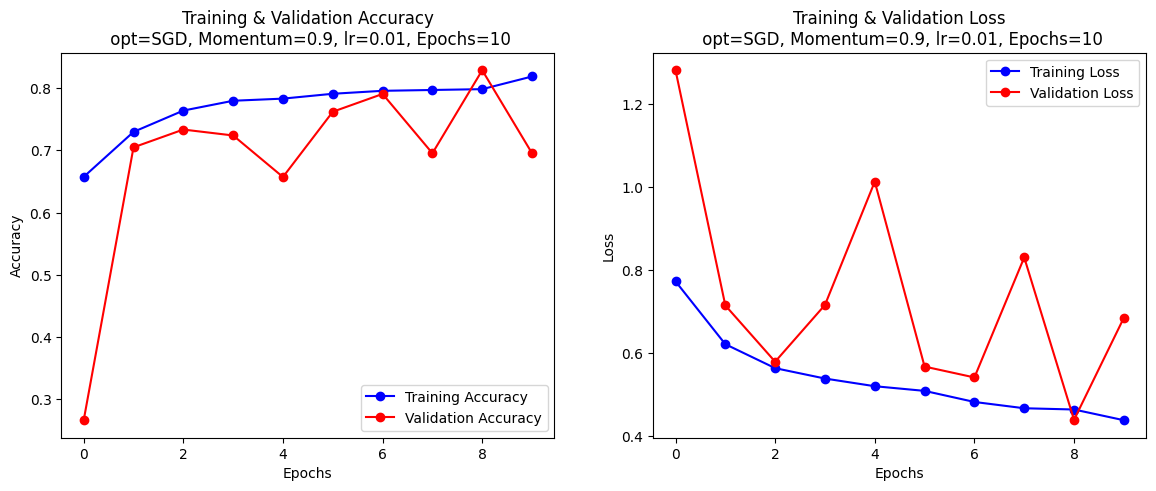

Epoch 1/10
329/329 [==============================] - 13s 37ms/step - loss: 0.6440 - accuracy: 0.7288 - val_loss: 3.0214 - val_accuracy: 0.2476
Epoch 2/10
329/329 [==============================] - 12s 36ms/step - loss: 0.4851 - accuracy: 0.7892 - val_loss: 1.9556 - val_accuracy: 0.3714
Epoch 3/10
329/329 [==============================] - 12s 36ms/step - loss: 0.4450 - accuracy: 0.8075 - val_loss: 0.4832 - val_accuracy: 0.8000
Epoch 4/10
329/329 [==============================] - 12s 36ms/step - loss: 0.4045 - accuracy: 0.8259 - val_loss: 0.7106 - val_accuracy: 0.7619
Epoch 5/10
329/329 [==============================] - 12s 37ms/step - loss: 0.3829 - accuracy: 0.8379 - val_loss: 0.4626 - val_accuracy: 0.8286
Epoch 6/10
329/329 [==============================] - 12s 37ms/step - loss: 0.3393 - accuracy: 0.8554 - val_loss: 0.4651 - val_accuracy: 0.8190
Epoch 7/10
329/329 [==============================] - 12s 37ms/step - loss: 0.2961 - accuracy: 0.8807 - val_loss: 0.9301 - val_accuracy:

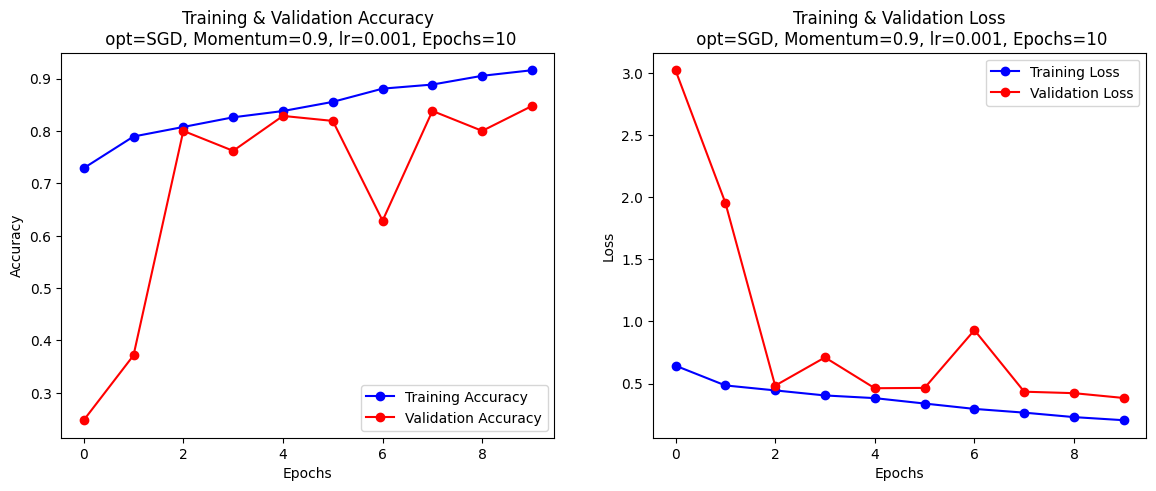

Epoch 1/10
329/329 [==============================] - 13s 37ms/step - loss: 0.6907 - accuracy: 0.7087 - val_loss: 2.2233 - val_accuracy: 0.2762
Epoch 2/10
329/329 [==============================] - 12s 37ms/step - loss: 0.5238 - accuracy: 0.7773 - val_loss: 1.1174 - val_accuracy: 0.5238
Epoch 3/10
329/329 [==============================] - 12s 37ms/step - loss: 0.4852 - accuracy: 0.7891 - val_loss: 0.6487 - val_accuracy: 0.7714
Epoch 4/10
329/329 [==============================] - 12s 37ms/step - loss: 0.4661 - accuracy: 0.7986 - val_loss: 0.6615 - val_accuracy: 0.7429
Epoch 5/10
329/329 [==============================] - 12s 37ms/step - loss: 0.4217 - accuracy: 0.8202 - val_loss: 0.4661 - val_accuracy: 0.8095
Epoch 6/10
329/329 [==============================] - 12s 36ms/step - loss: 0.4087 - accuracy: 0.8293 - val_loss: 0.6347 - val_accuracy: 0.7524
Epoch 7/10
329/329 [==============================] - 12s 37ms/step - loss: 0.3865 - accuracy: 0.8400 - val_loss: 0.5426 - val_accuracy:

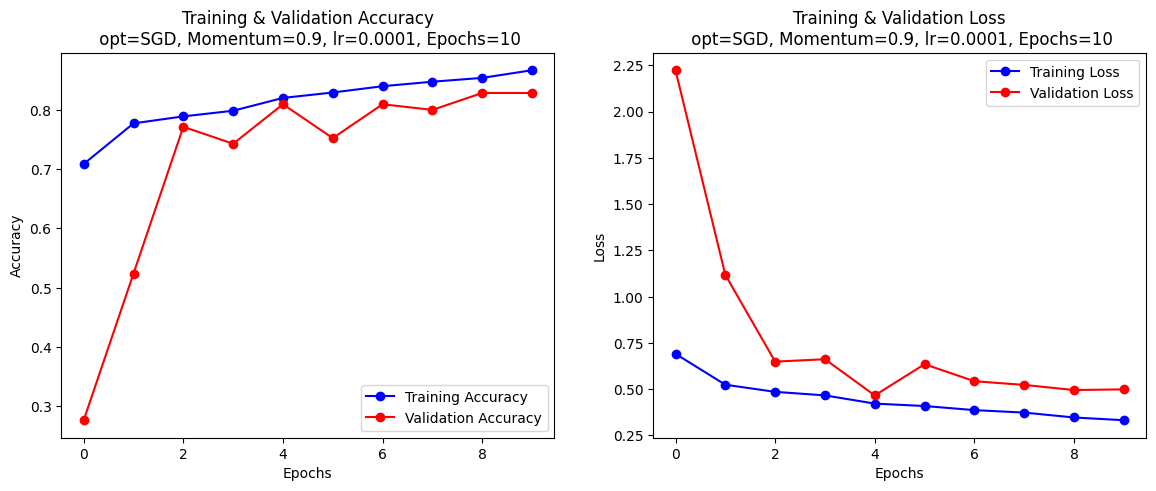

Epoch 1/20
329/329 [==============================] - 13s 37ms/step - loss: 0.7949 - accuracy: 0.6638 - val_loss: 1.3019 - val_accuracy: 0.2571
Epoch 2/20
329/329 [==============================] - 12s 36ms/step - loss: 0.6150 - accuracy: 0.7296 - val_loss: 0.5873 - val_accuracy: 0.7524
Epoch 3/20
329/329 [==============================] - 12s 36ms/step - loss: 0.5637 - accuracy: 0.7617 - val_loss: 0.6511 - val_accuracy: 0.7524
Epoch 4/20
329/329 [==============================] - 12s 36ms/step - loss: 0.5588 - accuracy: 0.7681 - val_loss: 0.4219 - val_accuracy: 0.8286
Epoch 5/20
329/329 [==============================] - 12s 36ms/step - loss: 0.5240 - accuracy: 0.7792 - val_loss: 0.7004 - val_accuracy: 0.7333
Epoch 6/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4928 - accuracy: 0.7989 - val_loss: 0.7652 - val_accuracy: 0.6762
Epoch 7/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4876 - accuracy: 0.7991 - val_loss: 0.4289 - val_accuracy:

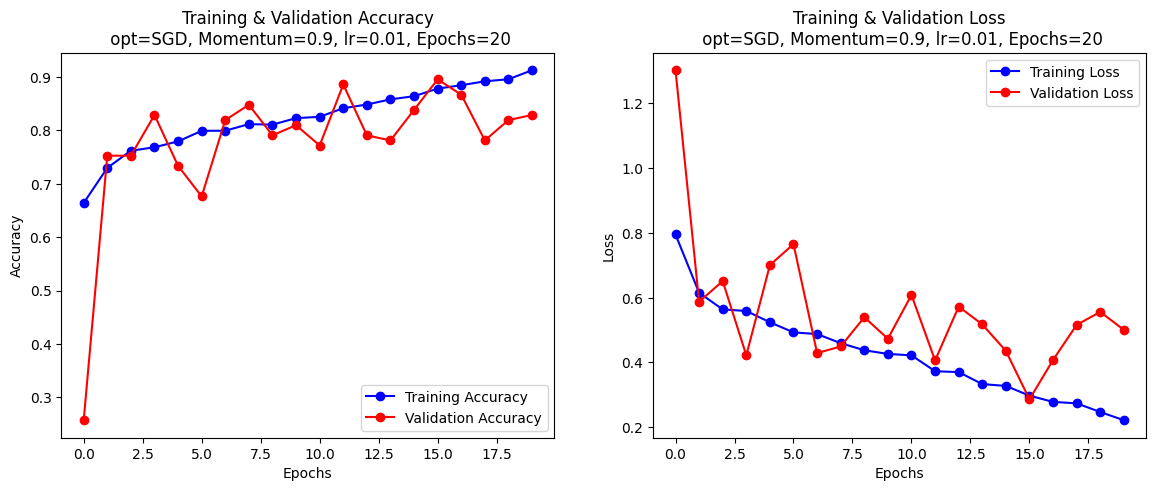

Epoch 1/20
329/329 [==============================] - 13s 37ms/step - loss: 0.6394 - accuracy: 0.7326 - val_loss: 1.9763 - val_accuracy: 0.2476
Epoch 2/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4900 - accuracy: 0.7946 - val_loss: 0.4972 - val_accuracy: 0.7810
Epoch 3/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4433 - accuracy: 0.8124 - val_loss: 0.7296 - val_accuracy: 0.7619
Epoch 4/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4106 - accuracy: 0.8265 - val_loss: 0.5465 - val_accuracy: 0.8000
Epoch 5/20
329/329 [==============================] - 12s 36ms/step - loss: 0.3760 - accuracy: 0.8430 - val_loss: 0.4831 - val_accuracy: 0.8476
Epoch 6/20
329/329 [==============================] - 12s 36ms/step - loss: 0.3533 - accuracy: 0.8489 - val_loss: 0.5786 - val_accuracy: 0.7524
Epoch 7/20
329/329 [==============================] - 12s 36ms/step - loss: 0.3135 - accuracy: 0.8719 - val_loss: 0.4897 - val_accuracy:

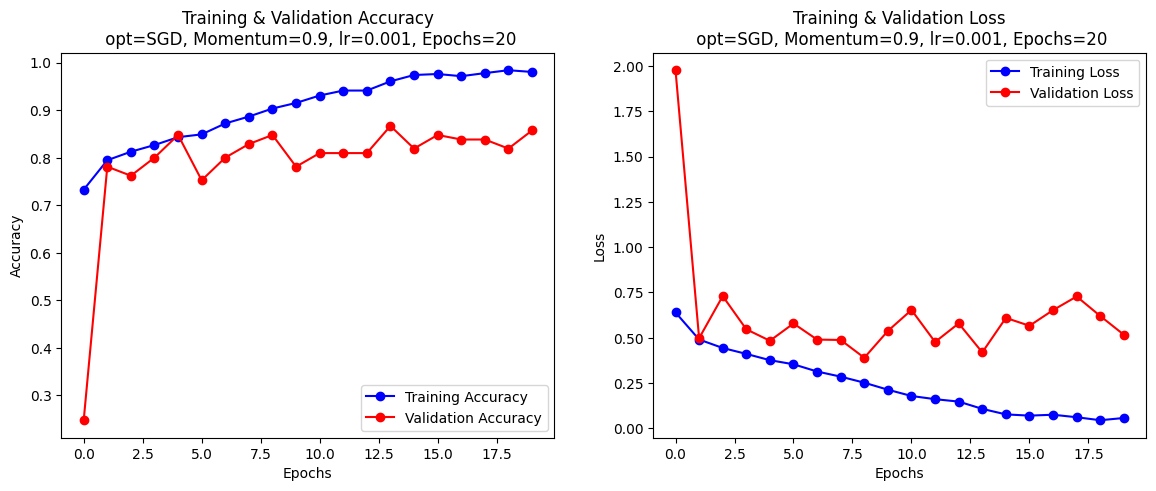

Epoch 1/20
329/329 [==============================] - 13s 37ms/step - loss: 0.6740 - accuracy: 0.7090 - val_loss: 2.2682 - val_accuracy: 0.2190
Epoch 2/20
329/329 [==============================] - 12s 36ms/step - loss: 0.5365 - accuracy: 0.7634 - val_loss: 0.9144 - val_accuracy: 0.5619
Epoch 3/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4945 - accuracy: 0.7883 - val_loss: 0.6332 - val_accuracy: 0.7238
Epoch 4/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4568 - accuracy: 0.8077 - val_loss: 0.6731 - val_accuracy: 0.6762
Epoch 5/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4356 - accuracy: 0.8122 - val_loss: 0.5466 - val_accuracy: 0.7714
Epoch 6/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4032 - accuracy: 0.8301 - val_loss: 0.5936 - val_accuracy: 0.7333
Epoch 7/20
329/329 [==============================] - 12s 36ms/step - loss: 0.3836 - accuracy: 0.8350 - val_loss: 0.4951 - val_accuracy:

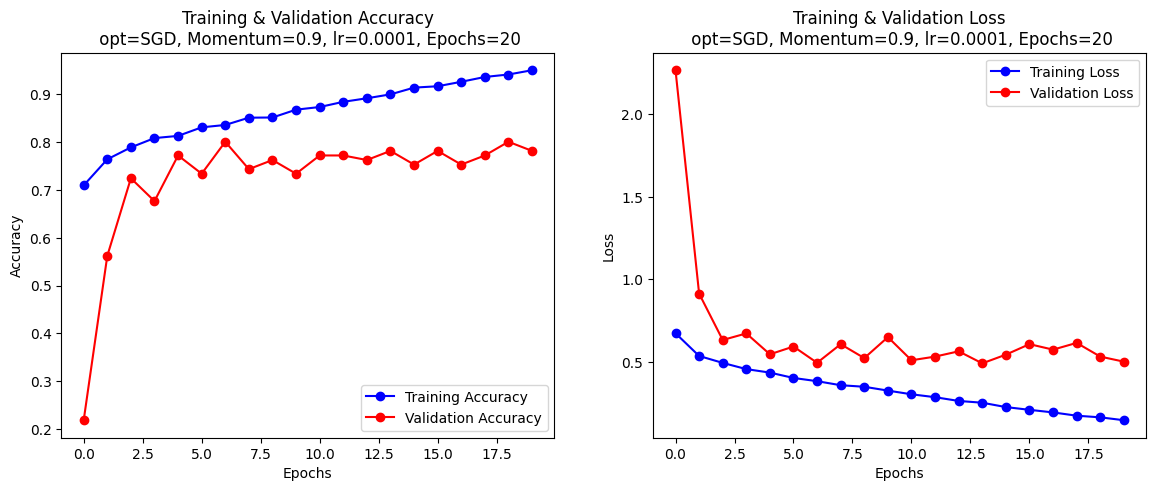

Epoch 1/40
329/329 [==============================] - 13s 37ms/step - loss: 0.7488 - accuracy: 0.6889 - val_loss: 1.1836 - val_accuracy: 0.3143
Epoch 2/40
329/329 [==============================] - 12s 36ms/step - loss: 0.6195 - accuracy: 0.7296 - val_loss: 0.7328 - val_accuracy: 0.6190
Epoch 3/40
329/329 [==============================] - 12s 36ms/step - loss: 0.5647 - accuracy: 0.7558 - val_loss: 0.6997 - val_accuracy: 0.7429
Epoch 4/40
329/329 [==============================] - 12s 36ms/step - loss: 0.5379 - accuracy: 0.7581 - val_loss: 0.7406 - val_accuracy: 0.6952
Epoch 5/40
329/329 [==============================] - 12s 35ms/step - loss: 0.5117 - accuracy: 0.7889 - val_loss: 1.0492 - val_accuracy: 0.6476
Epoch 6/40
329/329 [==============================] - 12s 35ms/step - loss: 0.5126 - accuracy: 0.7748 - val_loss: 0.4483 - val_accuracy: 0.8571
Epoch 7/40
329/329 [==============================] - 12s 35ms/step - loss: 0.4749 - accuracy: 0.7984 - val_loss: 0.4608 - val_accuracy:

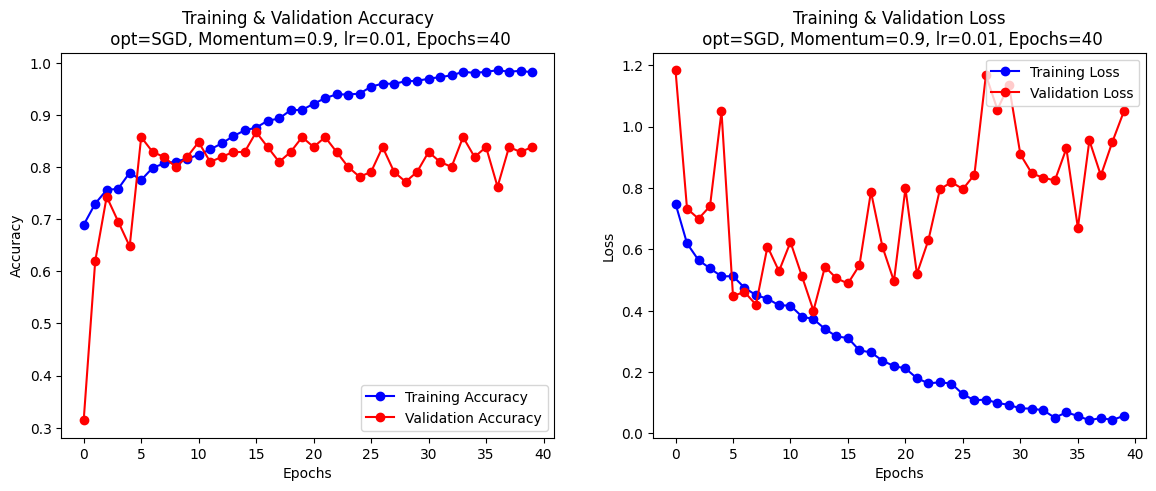

Epoch 1/40
329/329 [==============================] - 14s 39ms/step - loss: 0.6272 - accuracy: 0.7292 - val_loss: 3.3351 - val_accuracy: 0.2571
Epoch 2/40
329/329 [==============================] - 12s 37ms/step - loss: 0.4873 - accuracy: 0.7906 - val_loss: 0.6054 - val_accuracy: 0.7333
Epoch 3/40
329/329 [==============================] - 12s 37ms/step - loss: 0.4391 - accuracy: 0.8082 - val_loss: 0.4966 - val_accuracy: 0.8286
Epoch 4/40
329/329 [==============================] - 12s 37ms/step - loss: 0.4010 - accuracy: 0.8259 - val_loss: 0.5585 - val_accuracy: 0.7905
Epoch 5/40
329/329 [==============================] - 12s 37ms/step - loss: 0.3683 - accuracy: 0.8451 - val_loss: 0.5043 - val_accuracy: 0.7714
Epoch 6/40
329/329 [==============================] - 12s 37ms/step - loss: 0.3322 - accuracy: 0.8590 - val_loss: 0.5653 - val_accuracy: 0.8000
Epoch 7/40
329/329 [==============================] - 12s 36ms/step - loss: 0.2995 - accuracy: 0.8788 - val_loss: 0.4263 - val_accuracy:

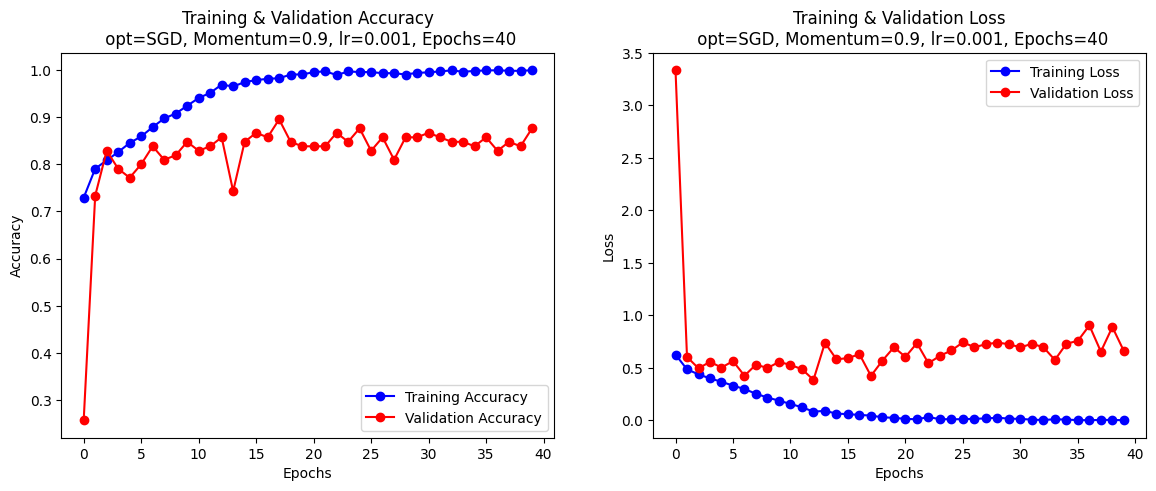

Epoch 1/40
329/329 [==============================] - 13s 37ms/step - loss: 0.6425 - accuracy: 0.7212 - val_loss: 1.8801 - val_accuracy: 0.2571
Epoch 2/40
329/329 [==============================] - 12s 37ms/step - loss: 0.5209 - accuracy: 0.7733 - val_loss: 0.9080 - val_accuracy: 0.6000
Epoch 3/40
329/329 [==============================] - 12s 37ms/step - loss: 0.4696 - accuracy: 0.7993 - val_loss: 0.5770 - val_accuracy: 0.7810
Epoch 4/40
329/329 [==============================] - 12s 37ms/step - loss: 0.4495 - accuracy: 0.8062 - val_loss: 0.6144 - val_accuracy: 0.7905
Epoch 5/40
329/329 [==============================] - 12s 37ms/step - loss: 0.4150 - accuracy: 0.8225 - val_loss: 0.5364 - val_accuracy: 0.8000
Epoch 6/40
329/329 [==============================] - 12s 37ms/step - loss: 0.3972 - accuracy: 0.8263 - val_loss: 0.5830 - val_accuracy: 0.7714
Epoch 7/40
329/329 [==============================] - 12s 37ms/step - loss: 0.3796 - accuracy: 0.8371 - val_loss: 0.7544 - val_accuracy:

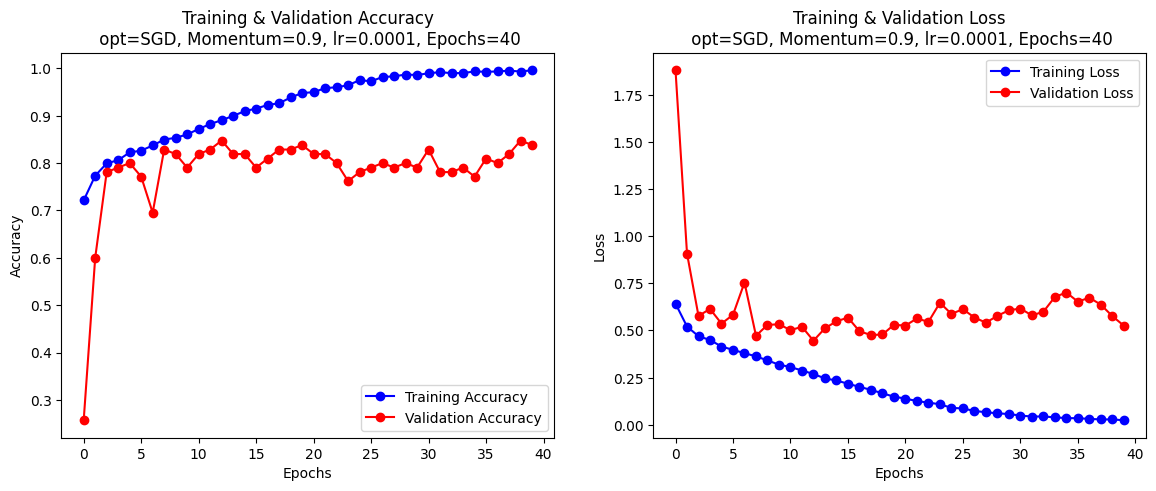

In [6]:
Epochs = [10, 20, 40]
learning_rates= [0.01, 0.001, 0.0001]

opt = SGD
momentum = 0.9

lr_epoch_test_acc = {}
lr_epoch_test_loss = {}
for Epoch in Epochs:
  for lr in learning_rates:
    model = create_model()
    model.compile(optimizer=opt(learning_rate=lr, momentum=momentum),
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=16,
                        epochs=Epoch, validation_data=(X_val, y_val))

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    lr_epoch_tuple = (Epoch, lr)
    lr_epoch_test_acc[lr_epoch_tuple] = test_accuracy
    lr_epoch_test_loss[lr_epoch_tuple] = test_loss
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    # Create a figure and subplot
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    # Plot the training and validation accuracy
    axs[0].plot(train_acc, 'bo-', label='Training Accuracy')
    axs[0].plot(val_acc, 'ro-', label='Validation Accuracy')
    axs[0].set_title(f'Training & Validation Accuracy\n opt={opt.__name__}, Momentum=0.9, lr={lr}, Epochs={Epoch}')
    # axs[0].title.set_size(10) # if title is too big, change the size here
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")

    # Plot the training and validation loss
    axs[1].plot(train_loss, 'bo-', label='Training Loss')
    axs[1].plot(val_loss, 'ro-', label='Validation Loss')
    axs[1].set_title(f'Training & Validation Loss\n opt={opt.__name__}, Momentum=0.9, lr={lr}, Epochs={Epoch}')
    # axs[1].title.set_size(10) # if title is too big, change the size here
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.2)

    plt.show()


Print the Loss & Accuracy Dictionaries

In [7]:
print(f"Test Accuracy and Loss Results with Optimizer: {opt.__name__}")
print()
print()
def print_results_dict(Accuracy, Loss):
    print("Print Accuracy Results")
    for key, val in Accuracy.items():
        epochs, lr = key
        print(f"Epochs Number = {epochs}, Learning Rate = {lr}, Accuracy = {val:.3f}")
    print()
    print()
    print("Print Loss Results")
    for key, val in Loss.items():
        epochs, lr = key
        print(f"Epochs Number = {epochs}, Learning Rate = {lr}, Loss = {val:.3f}")


print_results_dict(lr_epoch_test_acc, lr_epoch_test_loss)



Test Accuracy and Loss Results with Optimizer: SGD


Print Accuracy Results
Epochs Number = 10, Learning Rate = 0.01, Accuracy = 0.701
Epochs Number = 10, Learning Rate = 0.001, Accuracy = 0.818
Epochs Number = 10, Learning Rate = 0.0001, Accuracy = 0.806
Epochs Number = 20, Learning Rate = 0.01, Accuracy = 0.804
Epochs Number = 20, Learning Rate = 0.001, Accuracy = 0.810
Epochs Number = 20, Learning Rate = 0.0001, Accuracy = 0.816
Epochs Number = 40, Learning Rate = 0.01, Accuracy = 0.804
Epochs Number = 40, Learning Rate = 0.001, Accuracy = 0.816
Epochs Number = 40, Learning Rate = 0.0001, Accuracy = 0.822


Print Loss Results
Epochs Number = 10, Learning Rate = 0.01, Loss = 0.665
Epochs Number = 10, Learning Rate = 0.001, Loss = 0.528
Epochs Number = 10, Learning Rate = 0.0001, Loss = 0.471
Epochs Number = 20, Learning Rate = 0.01, Loss = 0.787
Epochs Number = 20, Learning Rate = 0.001, Loss = 0.779
Epochs Number = 20, Learning Rate = 0.0001, Loss = 0.501
Epochs Number = 40, Learnin